# **UUM540E Project 2**
## **Fuel Flow Estimation of an Aircraft via Operational Data**
###Prof. Gökhan İnalhan and Dr. M. Umut Demirezen
Prepared by Mevlüt Uzun

**Access to Drive**

The program will ask for your permission twice. You have to click the link, give the permission and copy the key to the text box.

**Install Useful Libraries**

In [0]:
!apt-get update
!apt-get install software-properties-common python-software-properties module-init-tools
!add-apt-repository ppa:alessandro-strada/ppa
!apt-get install google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/

In [0]:
!pip install imbalanced-learn
!pip install livelossplot
!pip install -U scikit-learn

**Import Libraries**

In [0]:
# Keras Libraries
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from livelossplot.keras import PlotLossesCallback
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras import backend as k
from keras.utils import multi_gpu_model
from keras.initializers import glorot_uniform
import tensorflow as tf
import random as rn
import os
import scipy.io as sio

# Pandas Libraries
import pandas as pd

# Numpy Libraries
import numpy as np
np.random.seed(27)

# File IO Libraries
import glob
import scipy.io as sio

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

# Data Preparation Libraries
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

os.environ['PYTHONHASHSEED'] = '0'

# Running the below code every time
np.random.seed(27)
rn.seed(27)
tf.set_random_seed(27)

sess = tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

In [11]:
# This will show the files for the given directory. It should be in your drive account.
!ls drive/'Colab Notebooks'/ML_HW2

DataSet1  DataSet2  Project_2.pdf  UUM540E_Project_2.ipynb


**Read Dataset**

In [0]:
# You must enter where your data is. 
trajectory_data = pd.read_pickle('drive/Colab Notebooks/ML_HW2/DataSet1')

In [0]:
# Once the program reads the data, it should appear like this.
trajectory_data

**Prepare the Data**

In [0]:
# Your features will be defined here. The example below is for two features: heading and its derivative
x_origin = np.column_stack( (trajectory_data['Heading (deg)'], trajectory_data['Heading Dot (deg/s)'], \
                             trajectory_data['Altitude (ft)'], trajectory_data['CAS (kt)'], \
                             trajectory_data['Mass (kg)'], trajectory_data['Air Pressure (mb)']) )
fuel_flow_of_engine_1 = np.array( trajectory_data['FF1 (lb/hr)']).reshape(-1, 1) * 0.000125998
fuel_flow_of_engine_2 = np.array( trajectory_data['FF2 (lb/hr)']).reshape(-1, 1) * 0.000125998
# Your output will be defined here. It should be the total fuel-flow from engines in [kg/s] 
y_origin = fuel_flow_of_engine_1 + fuel_flow_of_engine_2

# You must enter where your data is. 
trajectory_data2 = pd.read_pickle('drive/Colab Notebooks/ML_HW2/DataSet2')
x_test2 = np.column_stack( (trajectory_data2['Heading (deg)'], trajectory_data2['Heading Dot (deg/s)'], \
                            trajectory_data2['Altitude (ft)'], trajectory_data2['CAS (kt)'], \
                            trajectory_data2['Mass (kg)'], trajectory_data2['Air Pressure (mb)']) )
fuel_flow_of_engine_1 = np.array( trajectory_data2['FF1 (lb/hr)']).reshape(-1, 1) * 0.000125998
fuel_flow_of_engine_2 = np.array( trajectory_data2['FF2 (lb/hr)']).reshape(-1, 1) * 0.000125998
y_test2 = fuel_flow_of_engine_1 + fuel_flow_of_engine_2


# You will split your data into train and test sets. You have to enter the proper inputs to the train_test_split() function. See its documentation.
X_train, X_test, y_train, y_test = train_test_split( x_origin, y_origin, test_size=0.33, random_state=42 )

# You will normalize or scale your data by min-max or standard scalers. (i.e. MinMaxScaler or StandardScaler)
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

sc1 = scaler1.fit( X_train )
x_train_sc = sc1.transform( X_train )
x_test_sc = sc1.transform( X_test )

sc2 = scaler2.fit( y_train )
y_train_sc = sc2.transform( y_train )
y_test_sc = sc2.transform( y_test )

x_test2_sc = sc1.transform( x_test2 )
y_test2_sc = sc2.transform( y_test2 )

**Architecture of the Network**

In [102]:
print(aircraft_measurements.shape)
print(X_train.shape[1])
print(x_test2.shape)
print(y_test2.shape)

(?, 6)
6
(375379, 6)
(375379, 1)


In [0]:
k.clear_session() # Keep this line of code here to reset your networks parameters.


# Enter the number of inputs (features) from your data.
n_dims = X_train.shape[1]

# Define the input layer of the neural network. You can keep the line below.
aircraft_measurements = Input(shape=(n_dims,))

# Add a hidden layer to your neural network.
L1 = Dense(256, activation='relu',
         kernel_initializer=glorot_uniform(seed=42))(aircraft_measurements)

# You may have to add more hidden layers to get better results. 
L2 = Dense( 256, activation='relu',
         kernel_initializer=glorot_uniform(seed=42))(L1)

# Be careful at connecting the layers to each other.

# Define the output layer of the neural network.
fuel_flow = Dense(y_train_sc.shape[1], 
                  kernel_initializer=glorot_uniform(seed=42))(L2)

# Define the model as below. You don't have to change it.
model = Model(inputs=[aircraft_measurements], outputs=[fuel_flow])

# Compile your model. Select your optimization algorithm and loss function
model.compile(optimizer=Adam(), loss='mean_absolute_error' )

# Create a filename for your best model
model_name = 'my_model2.hdf5'

path="drive/Colab Notebooks/ML_HW2/" + model_name
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, period=1, mode='min')

**Train the Neural Network**

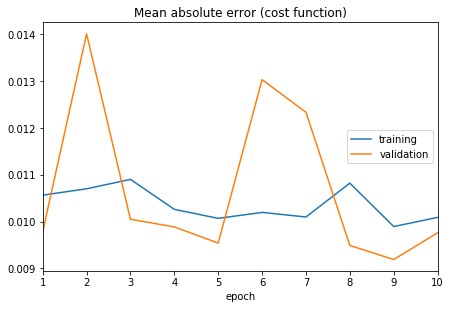

Mean absolute error (cost function):
training   (min:    0.010, max:    0.011, cur:    0.010)
validation (min:    0.009, max:    0.014, cur:    0.010)

Epoch 00010: loss did not improve from 0.00989


In [89]:
num_epochs = 10
batch_size = 1000
validation_size = 0.33

history = model.fit(x_train_sc, y_train_sc, 
                    batch_size=batch_size, epochs=num_epochs, shuffle=True, 
                    validation_split=validation_size, callbacks=[PlotLossesCallback(), checkpoint])

**Predict the Output of the Test Set**

In [0]:
# Load the model with best results
model = load_model(path)

# Make the prediction
y_predicted = model.predict(x_test_sc)

# Take inverse transform of your prediction (because it is scaled!)
y_predicted_inv = sc2.inverse_transform( y_predicted )

In [0]:
# Load the model with best results
model = load_model(path)

# Make the prediction
y_predicted2 = model.predict(x_test2_sc)

# Take inverse transform of your prediction (because it is scaled!)
y_predicted2_inv = sc2.inverse_transform( y_predicted2 )

**Print the Mean Absolute Error on the Test Set**

In [92]:
mae = str(np.round(mean_absolute_error(y_predicted_inv, y_test), 4))
print("Mean absolute error is :  " + mae + " (kg/s)")

Mean absolute error is :  0.0919 (kg/s)


In [104]:
mae = str(np.round(mean_absolute_error(y_predicted2_inv, y_test2), 4))
print("Mean absolute error for test set is :  " + mae + " (kg/s)")

Mean absolute error for test set is :  0.2069 (kg/s)
